# 3D MESH

In [1]:
import sys, os, glob
sys.path.append('../')

import numpy as np
from ipywidgets import interact, fixed

from MRIsegm.utils import get_slices, get_slices_info, get_rois, explore_slices, mask_slices, display_images
from MRIsegm.processing import denoise_slices, predict_slices, resize_slices
from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss
import tensorflow as tf
from tensorflow.keras.models import load_model
import segmentation_models as sm

Segmentation Models: using `keras` framework.


### Loading data

In [2]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted/'
patient = 'BO11/'
dir_path =  src + patient + 'T2AX'

slices_raw = get_slices(dir_path=dir_path)
alpha = 3
slices = denoise_slices(slices_raw, alpha = alpha)

get_slices_info(slices=slices)

roi_path = src + patient + 'T2ROI'

rois = get_rois(roi_path=roi_path) 
positions = [rois[i].get('position') - 1 for i in range(len(rois))]

# set(positions) to have unique values
print(f"number of masks = {len(set(positions))}")

The image object has the following dimensions: depth:30, height:512, width:512
number of masks = 17


### Loading models

In [3]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH =  256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

models_dir = '../data/models'
models_path = glob.glob(models_dir + '/*alpha3*.h5')

dependencies = {
    'DiceBCEloss': DiceBCEloss,
    'dice_coef': dice_coef,
    'FixedDropout': tf.keras.layers.Dropout(0.2),
    'jaccard_loss': sm.losses.JaccardLoss(class_weights=None, class_indexes=None, per_image=False, smooth=1.)

}

keys = [ os.path.splitext(os.path.split(models_path[i])[1])[0] for i, mod in enumerate(models_path)]
values = [ load_model(models_path[i], custom_objects=dependencies) for i, mod in enumerate(models_path)]

models = dict(zip(keys, values))

In [4]:
test_model = values[0]
print(f'model: {keys[0]}')

predicted_images = predict_slices(slices, test_model, IMAGE_HEIGHT, IMAGE_WIDTH, 0.8, dtype=np.uint8)

model: efficientnetb0_256_256_BTC=8_alpha3_OPT=Adam_LOSS=DiceBCEloss


### Resizing masks and original slices

In [5]:
slices_of_masks = mask_slices(slices=slices, rois=rois)
masks_resized = resize_slices(slices=slices_of_masks, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH, dtype=np.uint8)

slices_resized = resize_slices(slices=slices, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH)

### Showing predicted layer 

In [6]:
kwargs = dict(figsize=(8,8), fontsize=25)
interact(explore_slices, slices=fixed(predicted_images), layer=(0, slices.shape[0]-1), kwargs=fixed(kwargs))

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

<function MRIsegm.utils.explore_slices(slices, layer, **kwargs)>

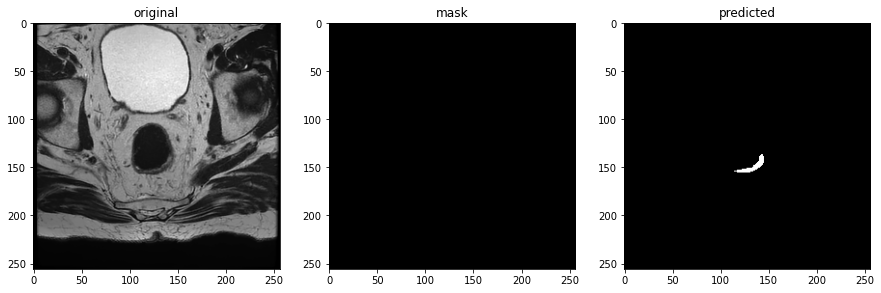

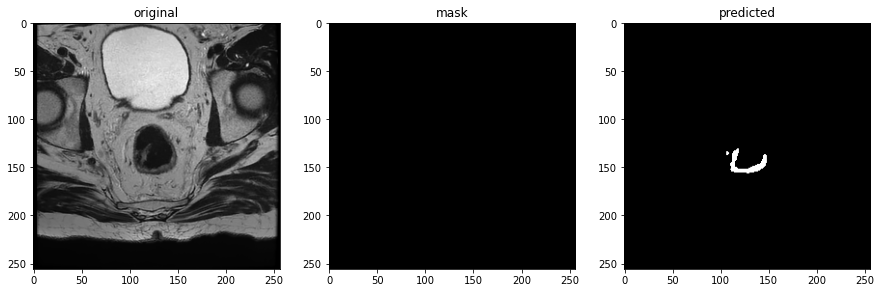

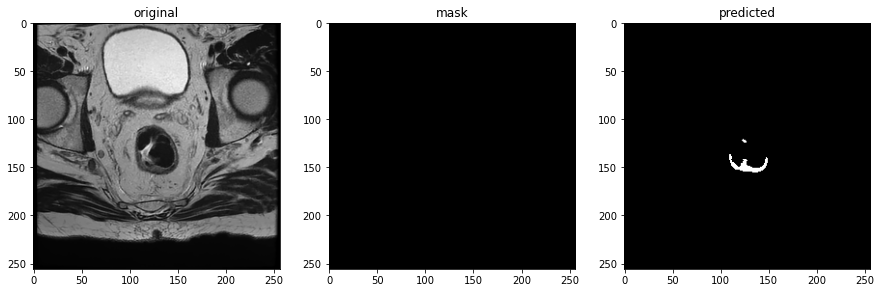

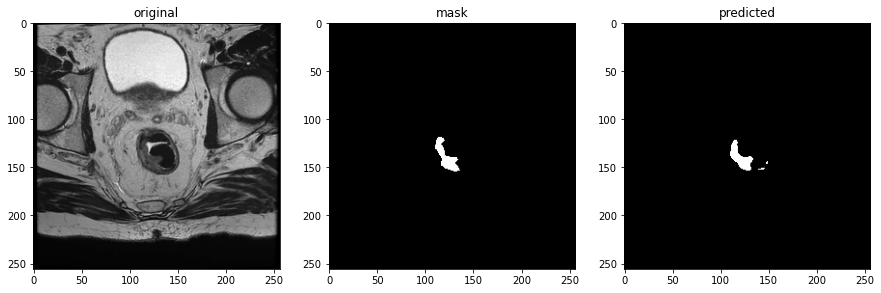

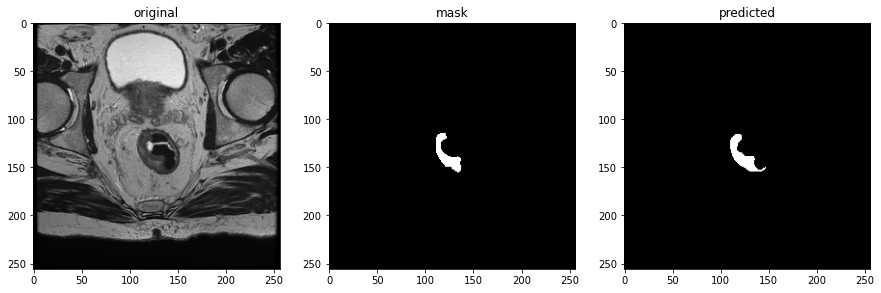

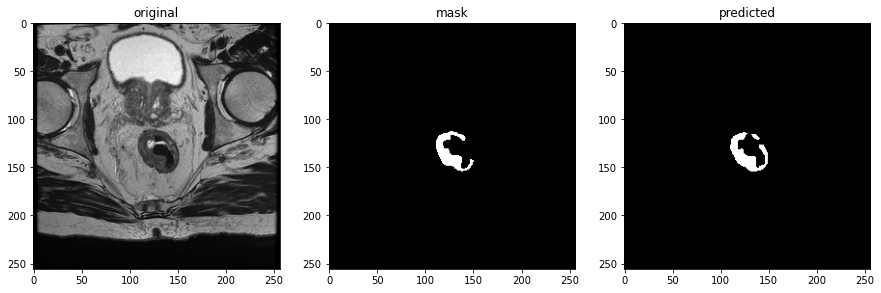

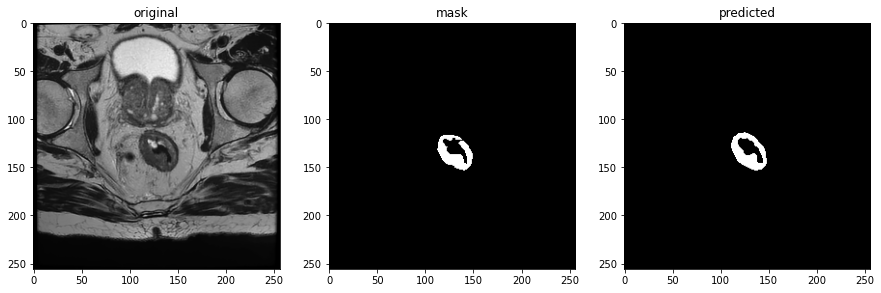

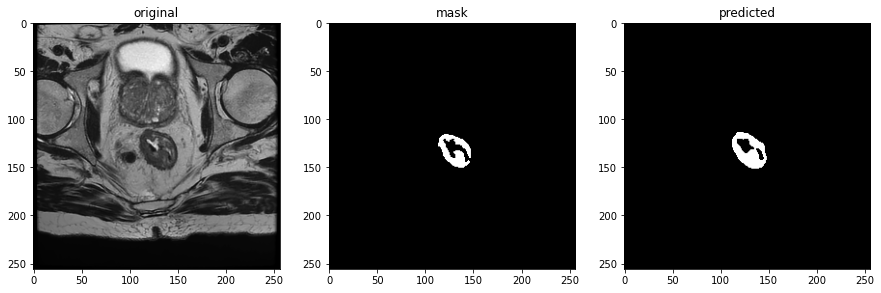

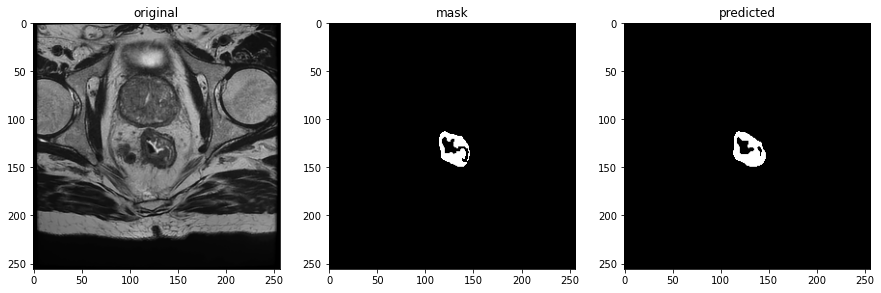

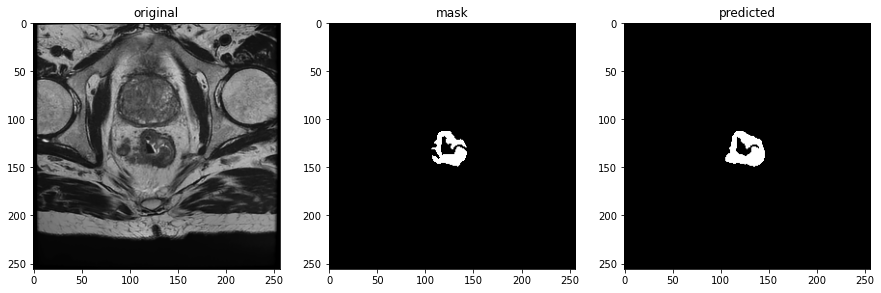

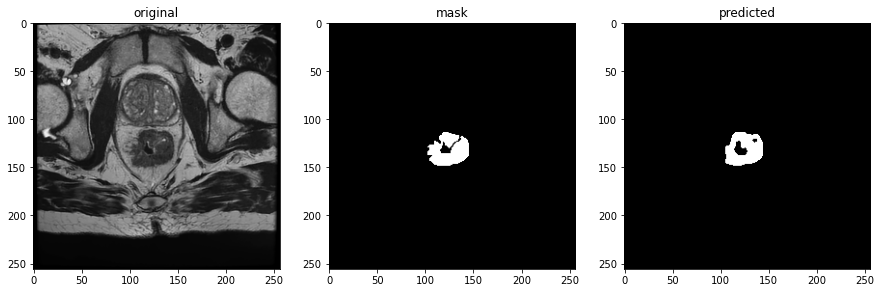

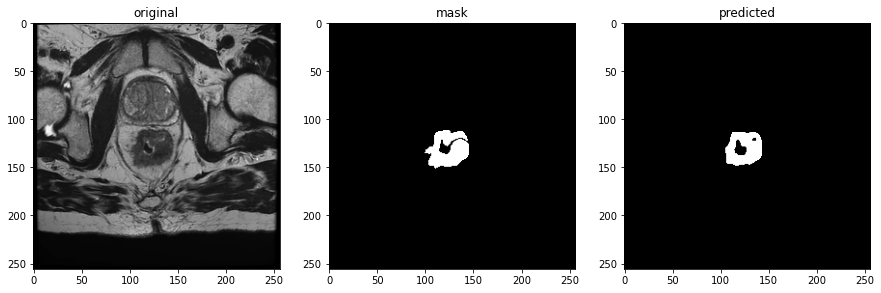

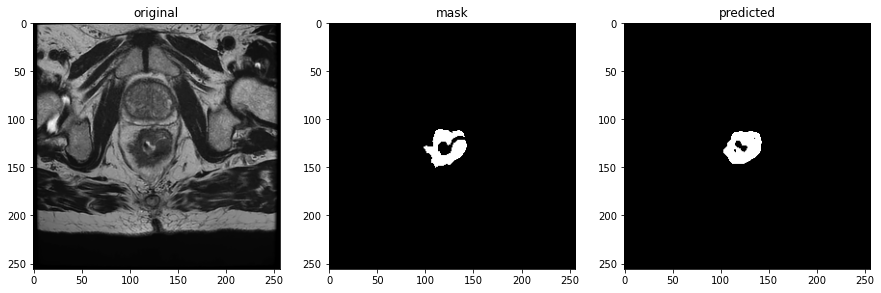

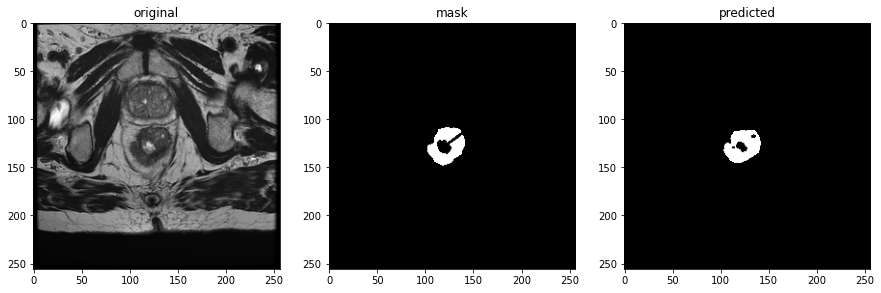

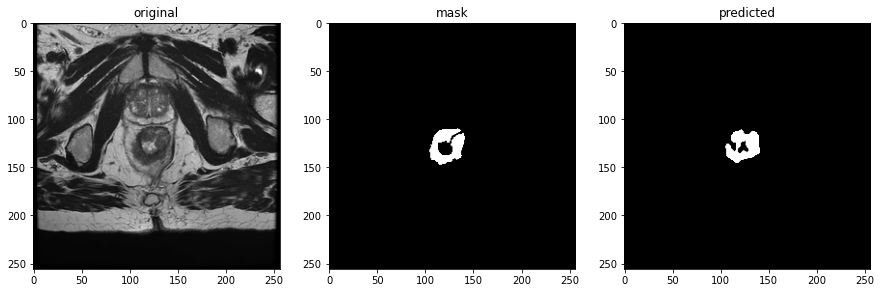

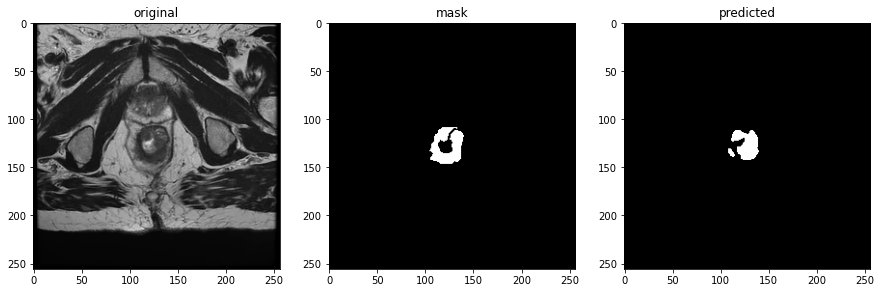

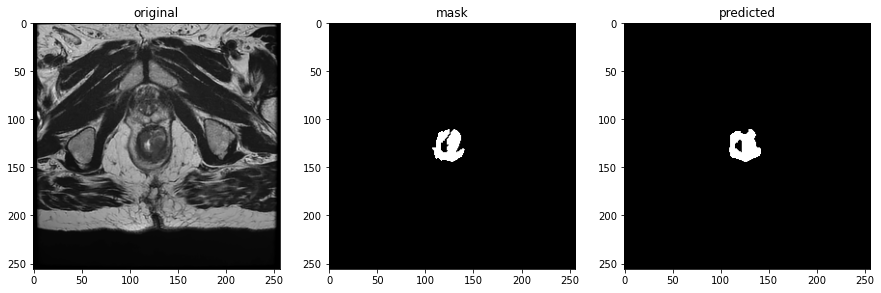

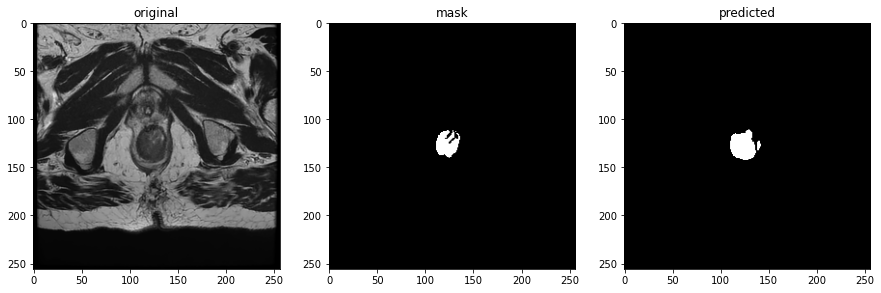

In [7]:
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19]

for i in layers:
    original = slices_resized[i, ...]
    mask = masks_resized[i, ...]
    predicted = predicted_images[i, ...]
    display_images([original, mask, predicted],figsize=(15,5), titles=['original', 'mask', 'predicted'])


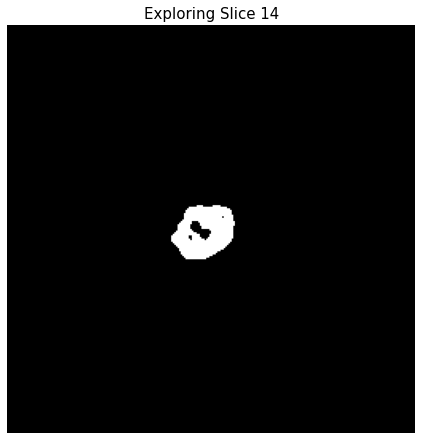

In [12]:
explore_slices(slices=predicted_images, layer=14)

### Mesh-plot

In [13]:
from skimage.measure import marching_cubes
squeezed = np.squeeze(predicted_images)
vertices_, faces_, _,_ = marching_cubes(squeezed)

squeezed_masks = np.squeeze(masks_resized)
vertices_masks, faces_masks ,_,_ = marching_cubes(squeezed_masks)

### predicted

In [14]:
import meshplot as mp 
mp.plot(vertices_, faces_)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(14.5, 133…

### annotation 

In [15]:
mp.plot(vertices_masks, faces_masks)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(11.0, 132…